<a href="https://colab.research.google.com/github/nikitakaraevv/pointnet/blob/master/nbs/PointNetClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PointNet

This is an implementation of [PointNet: Deep Learning on Point Sets for 3D Classification and Segmentation](https://arxiv.org/abs/1612.00593) using PyTorch.


## Getting started

Don't forget to turn on GPU if you want to start training directly. 


**Runtime** -> **Change runtime type**-> **Hardware accelerator**



In [1]:
from torch_geometric.datasets import GeometricShapes
from torch_geometric.datasets import ModelNet
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import KNNGraph, SamplePoints
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score, jaccard_score
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from torch import Tensor
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import MessagePassing
dataset = ModelNet(root='data/ModelNet10', name='10', train=True)

/home/rezoan/anaconda3/envs/pointnet_env/lib/python3.8/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /home/rezoan/anaconda3/envs/pointnet_env/lib/python3.8/site-packages/libpyg.so: undefined symbol: _ZN3c1010Dispatcher17runRecordFunctionERN2at14RecordFunctionESt17reference_wrapperIKNS_14FunctionSchemaEENS_11DispatchKeyE
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/home/rezoan/anaconda3/envs/pointnet_env/lib/python3.8/site-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /home/rezoan/anaconda3/envs/pointnet_env/lib/python3.8/site-packages/torch_spline_conv/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(
/home/rezoan/anaconda3/envs/pointnet_env/lib/python3.8/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importin

In [2]:
print(dataset)

ModelNet10(3991)


In [3]:
data = dataset[0]

In [4]:
print(data.y)

tensor([0])


In [5]:
import torch_geometric.transforms as T

dataset.transform = T.SamplePoints(num=256)

data = dataset[0]
print(data.y)

tensor([0])


In [6]:
from torch_geometric.transforms import SamplePoints, KNNGraph

dataset.transform = T.Compose([SamplePoints(num=256), KNNGraph(k=6)])

data = dataset[0]
print(data)

Data(pos=[256, 3], y=[1], edge_index=[2, 1536])


In [7]:
print(f"Number of classes: {dataset.num_classes}")

Number of classes: 10


In [8]:

import torch
from torch import nn

class TNet(nn.Module):
    def __init__(self, k):
        super(TNet, self).__init__()
        self.k = k
        self.conv1 = nn.Conv1d(k, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k * k)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

        self.relu = nn.ReLU()

    def forward(self, x):
        batch_size = x.size(0)

        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=False)[0]

        x = self.relu(self.bn4(self.fc1(x)))
        x = self.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = torch.eye(self.k, requires_grad=True).repeat(batch_size, 1, 1).to(x.device)
        x = x.view(-1, self.k, self.k) + iden
        return x


In [9]:
class PointNetLayer(MessagePassing):
    def __init__(self, in_channels: int, out_channels: int, use_tnet: bool = True):
        super().__init__(aggr='max')
        self.use_tnet = use_tnet
        self.tnet = TNet(k=in_channels) if use_tnet else None
        self.mlp = Sequential(
            Linear(in_channels if not use_tnet else in_channels * 2, out_channels),
            ReLU()
        )
    
    def forward(self, x: Tensor, pos: Tensor):
        if self.use_tnet:
            trans = self.tnet(x.transpose(1, 2)).transpose(1, 2)
            x = torch.bmm(x, trans)
        return self.mlp(torch.cat([x, pos], dim=-1))
            
    def __init__(self, in_channels: int, out_channels: int):
        # Message passing with "max" aggregation.
        super().__init__(aggr='max')

        # Initialization of the MLP:
        # Here, the number of input features correspond to the hidden
        # node dimensionality plus point dimensionality (=3).
        self.mlp = Sequential(
            Linear(in_channels + 3, out_channels),
            ReLU(),
            Linear(out_channels, out_channels),
        )

    def forward(self,
        h: Tensor,
        pos: Tensor,
        edge_index: Tensor,
    ) -> Tensor:
        # Start propagating messages.
        return self.propagate(edge_index, h=h, pos=pos)

    def message(self,
        h_j: Tensor,
        pos_j: Tensor,
        pos_i: Tensor,
    ) -> Tensor:
        # h_j: The features of neighbors as shape [num_edges, in_channels]
        # pos_j: The position of neighbors as shape [num_edges, 3]
        # pos_i: The central node position as shape [num_edges, 3]

        edge_feat = torch.cat([h_j, pos_j - pos_i], dim=-1)
        return self.mlp(edge_feat)

In [10]:
from torch_geometric.nn import global_max_pool
import torch

class PointNet(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = PointNetLayer(3, 32)
        # self.conv2 = PointNetLayer(32, 32)
        self.classifier = Linear(32, dataset.num_classes)

    def forward(self,
        pos: Tensor,
        edge_index: Tensor,
        batch: Tensor,
    ) -> Tensor:

        # Perform two-layers of message passing:
        h = self.conv1(h=pos, pos=pos, edge_index=edge_index)
        h = h.relu()
        # h = self.conv2(h=h, pos=pos, edge_index=edge_index)
        # h = h.relu()

        # Global Pooling:
        h = global_max_pool(h, batch)  # [num_examples, hidden_channels]

        # Classifier:
        return self.classifier(h)


model = PointNet()

In [11]:
print(model)

PointNet(
  (conv1): PointNetLayer()
  (classifier): Linear(in_features=32, out_features=10, bias=True)
)


In [12]:


# Dataset and transforms
train_dataset = GeometricShapes(root='data/ModelNet10', train=True)
train_dataset.transform = T.Compose([SamplePoints(num=256), KNNGraph(k=6)])
test_dataset = GeometricShapes(root='data/ModelNet10', train=False)
test_dataset.transform = T.Compose([SamplePoints(num=256), KNNGraph(k=6)])

# Split train_dataset into training and validation (80-20 split)
train_indices, val_indices = train_test_split(range(len(train_dataset)), test_size=0.2, random_state=42)
train_subset = torch.utils.data.Subset(train_dataset, train_indices)
val_subset = torch.utils.data.Subset(train_dataset, val_indices)

# Data loaders
train_loader = DataLoader(train_subset, batch_size=10, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=10, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=10)

# Model, optimizer, and loss
model = PointNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()


In [13]:

# Training function
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        logits = model(data.pos, data.edge_index, data.batch)
        loss = criterion(logits, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
    return total_loss / len(train_loader.dataset)

# Validation function
@torch.no_grad()
def validate():
    model.eval()
    total_correct = 0
    total_loss = 0
    all_preds, all_labels = [], []
    for data in val_loader:
        logits = model(data.pos, data.edge_index, data.batch)
        loss = criterion(logits, data.y).item()
        total_loss += loss * data.num_graphs
        pred = logits.argmax(dim=-1)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(data.y.cpu().numpy())
        total_correct += int((pred == data.y).sum())
    accuracy = total_correct / len(val_loader.dataset)
    return total_loss / len(val_loader.dataset), accuracy, all_preds, all_labels

# Test function
@torch.no_grad()
def test():
    model.eval()
    total_correct = 0
    all_preds, all_labels = [], []
    for data in test_loader:
        logits = model(data.pos, data.edge_index, data.batch)
        pred = logits.argmax(dim=-1)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(data.y.cpu().numpy())
        total_correct += int((pred == data.y).sum())
    accuracy = total_correct / len(test_loader.dataset)
    return accuracy, all_preds, all_labels

# Tracking metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(1, 51):
    train_loss = train()
    val_loss, val_acc, _, _ = validate()
    _, train_acc, _,_ = validate()
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    print(f'Epoch: {epoch:02d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

# Test after training
test_acc, test_preds, test_labels = test()
print(f'Test Accuracy: {test_acc:.4f}')



Epoch: 01, Train Loss: 12.5927, Val Loss: 11.4104, Train Acc: 0.3504, Val Acc: 0.3579
Epoch: 02, Train Loss: 8.1237, Val Loss: 8.1612, Train Acc: 0.3354, Val Acc: 0.3367
Epoch: 03, Train Loss: 2.7464, Val Loss: 1.8997, Train Acc: 0.3254, Val Acc: 0.3254
Epoch: 04, Train Loss: 1.8667, Val Loss: 1.8688, Train Acc: 0.3404, Val Acc: 0.3367
Epoch: 05, Train Loss: 1.8032, Val Loss: 1.8443, Train Acc: 0.3492, Val Acc: 0.3667
Epoch: 06, Train Loss: 1.7513, Val Loss: 1.7929, Train Acc: 0.3454, Val Acc: 0.3529
Epoch: 07, Train Loss: 1.6544, Val Loss: 1.6009, Train Acc: 0.4518, Val Acc: 0.4431
Epoch: 08, Train Loss: 1.5999, Val Loss: 3.0991, Train Acc: 0.4493, Val Acc: 0.4531
Epoch: 09, Train Loss: 1.5367, Val Loss: 1.5423, Train Acc: 0.4418, Val Acc: 0.4368
Epoch: 10, Train Loss: 1.4797, Val Loss: 1.5226, Train Acc: 0.4418, Val Acc: 0.4656
Epoch: 11, Train Loss: 1.4398, Val Loss: 1.5650, Train Acc: 0.4568, Val Acc: 0.4756
Epoch: 12, Train Loss: 1.4747, Val Loss: 1.5058, Train Acc: 0.4881, Val Ac

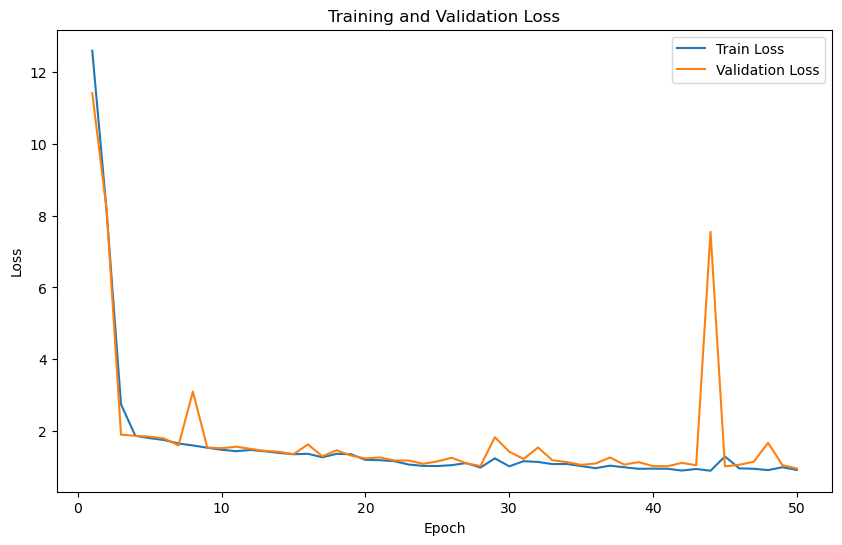

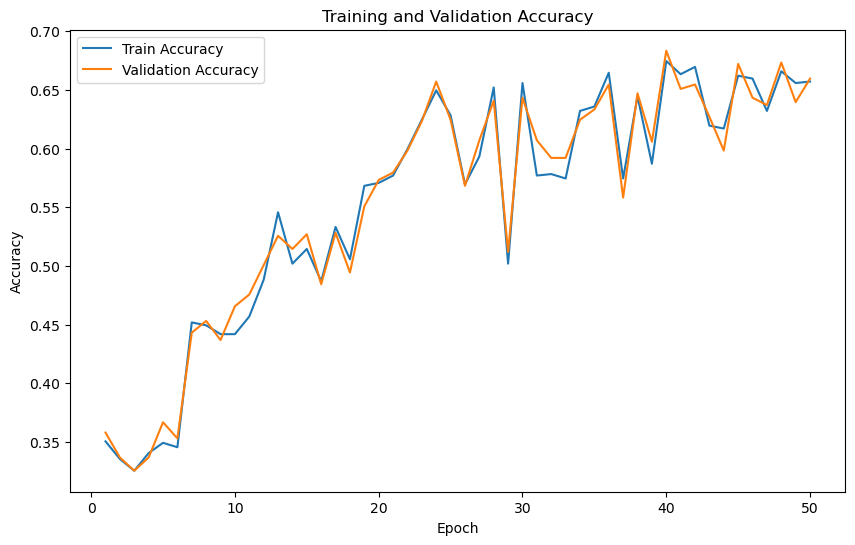

In [14]:
# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()


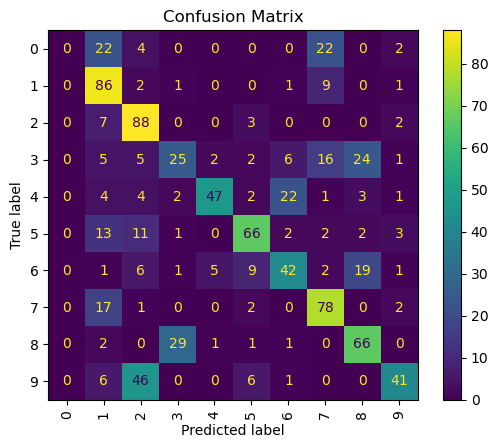

Recall: 0.5576, IoU: 0.3889


In [15]:
# Plot Confusion Matrix
cm = confusion_matrix(test_labels, test_preds, labels=range(10))  # Added missing closing parenthesis
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))
disp.plot(cmap="viridis", xticks_rotation="vertical")
plt.title("Confusion Matrix")
plt.show()

# Calculate Recall and IoU
recall = recall_score(test_labels, test_preds, average="macro")
iou = jaccard_score(test_labels, test_preds, average="macro")
print(f'Recall: {recall:.4f}, IoU: {iou:.4f}')
